<a href="https://colab.research.google.com/github/Murktalpur/transformer-models-for-tweet-classification-on-turkey-earthquake/blob/main/trying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers

In [2]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import TensorDataset, DataLoader

In [3]:
!pip install datasets

In [4]:
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np

In [5]:
!pip install evaluate

In [6]:
import evaluate
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
import seaborn as sns

In [9]:
plt.style.use('ggplot')

In [10]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [11]:
df = pd.read_csv('/content/dataset.csv').drop(['Unnamed: 0'], axis=1)

In [12]:
df = df.rename(columns={'Tweets': 'text', 'Class': 'label'})

In [13]:
train, validation = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
df.head()

,text,label
0,Kahramanmaraş türkoğlu ilçesi şekeroba köyü ça...,1.0
1,"Teyitli, ses var, köpekler tepki veriyor. Her...",1.0
2,0539 693 27 99 bu arkadaş Kahramanmaraş’ta çad...,1.0
3,Babamın yaşadığı yere henüz yardım ulaşmamış ş...,1.0
4,Samsun Atakum'da 18 adet yeni eşyalı daire var...,1.0


In [15]:
df.shape

(499, 2)

In [16]:
df["label"].unique()

array([1., 0.])

In [17]:
class_df = df.groupby('label').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

,label,text
1,1.000000,299
0,0.000000,200


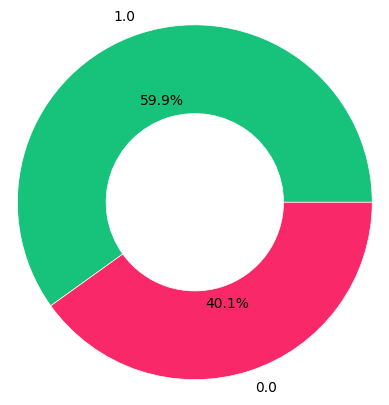

In [18]:
percent_class=class_df.text
labels= class_df.label

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white')
plt.savefig('Label Distribution.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [19]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(validation)

In [20]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True).remove_columns(["text","__index_level_0__"]).rename_column("label", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True).remove_columns(["text","__index_level_0__"]).rename_column("label", "labels")
train_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [21]:
train_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 399
})

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(test_dataset, batch_size=8)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [25]:
from transformers import get_scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [26]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print("")

In [27]:
model.config.problem_type = "multi_label_classification"

In [28]:
from tqdm.auto import tqdm
import torch.nn.functional as F
import evaluate
from sklearn.metrics import classification_report
progress_bar = tqdm(range(num_training_steps))


for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch["labels"] = torch.nn.functional.one_hot(batch["labels"].to(torch.int64), 2).to(torch.float)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()


        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    true_labels = []
    predicted_labels = []
    metric = evaluate.load("accuracy")
    for batch in eval_dataloader:
        batch["labels"] = torch.nn.functional.one_hot(batch["labels"].to(torch.int64), 2).to(torch.float)

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        batch["labels"] = torch.argmax(batch["labels"],dim=-1).to(torch.int32)
        true_labels.extend(batch["labels"].tolist())
        predicted_labels.extend(predictions.tolist())

        metric.add_batch(predictions=predictions, references=batch["labels"])
    print(metric.compute())

  0%|          | 0/150 [00:00<?, ?it/s]

{'accuracy': 0.87}
{'accuracy': 0.88}
{'accuracy': 0.89}


In [29]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels)
print('\tClassification Report for BERT:\n\n',report)

	Classification Report for BERT:

               precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.91      0.90      0.91        59

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



In [31]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(validation)

In [32]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True).remove_columns(["text","__index_level_0__"]).rename_column("label", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True).remove_columns(["text","__index_level_0__"]).rename_column("label", "labels")
train_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [33]:
train_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 399
})

In [34]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(test_dataset, batch_size=8)

In [35]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base",num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [37]:
from transformers import get_scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [38]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print("")

In [39]:
model.config.problem_type = "multi_label_classification"

In [40]:
from tqdm.auto import tqdm
import torch.nn.functional as F
import evaluate
from sklearn.metrics import classification_report
progress_bar = tqdm(range(num_training_steps))


for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch["labels"] = torch.nn.functional.one_hot(batch["labels"].to(torch.int64), 2).to(torch.float)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()


        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    true_labels = []
    predicted_labels = []
    metric = evaluate.load("accuracy")
    for batch in eval_dataloader:
        batch["labels"] = torch.nn.functional.one_hot(batch["labels"].to(torch.int64), 2).to(torch.float)

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        batch["labels"] = torch.argmax(batch["labels"],dim=-1).to(torch.int32)
        true_labels.extend(batch["labels"].tolist())
        predicted_labels.extend(predictions.tolist())

        metric.add_batch(predictions=predictions, references=batch["labels"])
    print(metric.compute())

  0%|          | 0/150 [00:00<?, ?it/s]

{'accuracy': 0.89}
{'accuracy': 0.89}
{'accuracy': 0.89}


In [41]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels)
print('\tClassification Report for Roberta:\n\n',report)

	Classification Report for Roberta:

               precision    recall  f1-score   support

           0       0.79      1.00      0.88        41
           1       1.00      0.81      0.90        59

    accuracy                           0.89       100
   macro avg       0.89      0.91      0.89       100
weighted avg       0.91      0.89      0.89       100



In [42]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(validation)

In [43]:
from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True).remove_columns(["text","__index_level_0__"]).rename_column("label", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True).remove_columns(["text","__index_level_0__"]).rename_column("label", "labels")
train_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [44]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(test_dataset, batch_size=8)

In [45]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [47]:
from transformers import get_scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [48]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print("")

In [49]:
model.config.problem_type = "multi_label_classification"

In [50]:
from tqdm.auto import tqdm
import torch.nn.functional as F
import evaluate
from sklearn.metrics import classification_report
progress_bar = tqdm(range(num_training_steps))


for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch["labels"] = torch.nn.functional.one_hot(batch["labels"].to(torch.int64), 2).to(torch.float)

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()


        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    true_labels = []
    predicted_labels = []
    metric = evaluate.load("accuracy")
    for batch in eval_dataloader:
        batch["labels"] = torch.nn.functional.one_hot(batch["labels"].to(torch.int64), 2).to(torch.float)

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        batch["labels"] = torch.argmax(batch["labels"],dim=-1).to(torch.int32)
        true_labels.extend(batch["labels"].tolist())
        predicted_labels.extend(predictions.tolist())

        metric.add_batch(predictions=predictions, references=batch["labels"])
    print(metric.compute())

  0%|          | 0/150 [00:00<?, ?it/s]

{'accuracy': 0.99}
{'accuracy': 0.97}
{'accuracy': 0.97}


In [51]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels)
print('\tClassification Report for Distilbert:\n\n',report)

	Classification Report for Distilbert:

               precision    recall  f1-score   support

           0       1.00      0.93      0.96        41
           1       0.95      1.00      0.98        59

    accuracy                           0.97       100
   macro avg       0.98      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100

